In [1]:
# Выгружаем все необходимые библиотеки
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Для отрисовки сетки за графиком
plt.rc('axes', axisbelow=True)

In [2]:
table = pd.read_excel(r'Test.xlsx')
table = table.loc[:,['RTKM_P','RTKM','MTSS','MGTS']]
n_assets = 4
n_obs = 10
stocks = ['RTKM_P', 'RTKM', 'MTSS', 'MGTS']
table

RTKM_P    RTKM    MTSS  MGTS
0     68.15   88.49  210.00   542
1     63.55   81.27  205.00   531
2     65.80   85.39  216.50   533
3     65.00   86.29  226.00   550
4     64.50   86.31  231.85   551
5     64.00   84.50  229.75   577
6     65.00   88.90  236.80   563
7     64.90   89.93  230.25   564
8     65.85   93.00  234.65   585
9     67.00   95.00  231.85   580
10    67.00   95.80  234.50   575
11    67.10   95.28  236.50   568
12    68.95   98.34  237.60   604
13    69.05   98.13  238.10   601
14    68.30   96.05  252.00   616
15    71.40  100.00  258.50   625
16    72.00   98.50  253.00   608
17    70.60   94.10  262.05   604
18    72.25   96.30  256.10   845
19    72.35   95.47  258.00   916
20    73.45   97.20  255.80   912
21    71.80   96.10  253.00   907
22    70.00   95.01  260.70   909
23    69.50   92.80  253.30   901
24    69.85   93.10  238.15   909
25    70.05   91.50  245.05   984
26    67.25   87.80  232.00   999
27    64.55   86.40  235.20   799
28    64.00   85.87  243.90   777
29    64.50   85.50  252.00   770
..      ...     ...     ...   ...
161   60.80   72.38  255.00  1784
162   60.15   72.57  260.45  1808
163   60.25   73.00  249.05  1800
164   60.25   72.90  252.60  1800
165   60.05   72.84  254.90  1792
166   59.85   72.60  260.00  1760
167   60.00   72.93  265.00  1762
168   60.15   72.51  252.45  1798
169   60.00   73.24  264.30  1854
170   60.20   73.78  259.05  1892
171   60.25   73.94  259.85  1900
172   60.40   74.02  257.00  1898
173   62.00   75.80  262.90  1920
174   61.60   74.40  255.40  1912
175   65.25   81.99  253.25  1960
176   62.30   79.84  256.70  1974
177   60.65   76.99  255.80  1952
178   61.35   78.20  263.15  1938
179   61.55   77.70  270.10  1986
180   63.90   80.28  277.85  2074
181   64.25   81.15  284.90  2030
182   65.15   79.37  284.95  2046
183   62.75   79.76  268.55  1734
184   64.55   84.11  262.40  1750
185   63.55   81.91  266.00  1760
186   63.45   82.30  261.75  1720
187   63.05   81.57  258.75  1730
188   61.95   82.00  254.00  1684
189   62.30   81.00  256.35  1722
190   62.15   81.01  266.35  1756

[191 rows x 4 columns]

In [3]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) * num_periods_annually
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(num_periods_annually)
    return std, returns

In [4]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

In [5]:
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [6]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

In [7]:
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)

    return result

In [8]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [9]:
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [10]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [24]:
num_portfolios = 25000 # Кол-во расчитываемых портфелей (итераций)
risk_free_rate = 0.04 # Безрисковая процентная ставка
num_periods_annually = 252 # Количество операционных дней в году

In [25]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()

In [26]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
min_vol = min_variance(mean_returns, cov_matrix)

In [27]:
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

In [28]:
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

In [29]:
target = np.linspace(rp_min, 0.017, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

In [30]:
results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

--------------------------------------------------------------------------------
Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:n
Годовая доходность: 1.3
Годовой риск: 0.576
Коэффициент Шарпа 2.19


            RTKM_P  RTKM   MTSS   MGTS
allocation     0.0   0.0  44.37  55.63
--------------------------------------------------------------------------------
Распределение долей акций в портфеле с наименьшим показателем риска:

Годовая доходность: 0.148
Годовой риск: 0.297
Коэффициент Шарпа: 0.364


            RTKM_P   RTKM   MTSS  MGTS
allocation   53.39  21.33  19.88  5.39


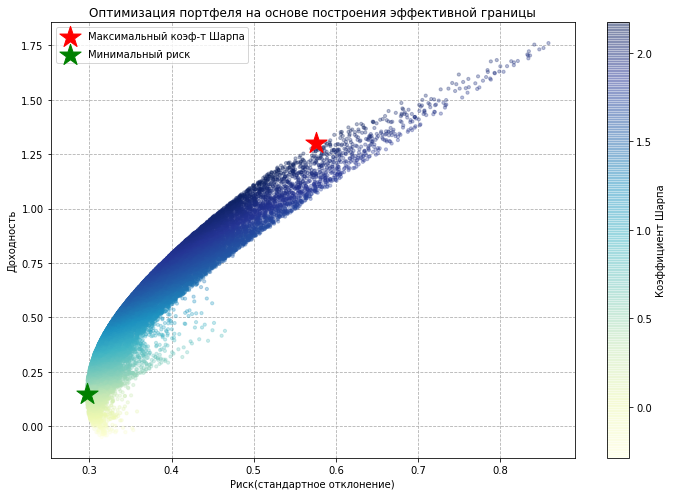

In [31]:
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа:n")
print("Годовая доходность:", round(rp,3))
print("Годовой риск:", round(sdp,3))
print("Коэффициент Шарпа", round((rp - risk_free_rate)/sdp, 3))
print("\n")
print(max_sharpe_allocation)
print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(rp_min,3))
print("Годовой риск:", round(sdp_min,3))
print("Коэффициент Шарпа:", round((rp_min - risk_free_rate)/sdp_min, 3))
print("\n")
print(min_vol_allocation)

plt.figure(figsize=(10, 7))
plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Коэффициент Шарпа')
plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Максимальный коэф-т Шарпа')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Минимальный риск')

plt.title('Оптимизация портфеля на основе построения эффективной границы')
plt.xlabel('Риск(стандартное отклонение)')
plt.ylabel('Доходность')
plt.grid(True, linestyle='--')
plt.legend(labelspacing=0.8)

plt.tight_layout();

In [32]:
max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
max_sharpe_allocation = max_sharpe_allocation.T

min_vol = min_variance(mean_returns, cov_matrix)
sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
min_vol_allocation = min_vol_allocation.T

an_vol = np.std(returns) * np.sqrt(num_periods_annually)
an_rt = mean_returns * num_periods_annually

In [33]:
target = np.linspace(rp_min, 0.017, 20)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)

In [34]:
print("-"*80)
print("Распределение долей акций в портфеле с максимальным коэффициентом Шарпа\n")
print("Годовая доходность:", round(rp,2))
print("Годовой риск:", round(sdp,2))
print("Коэффициент Шарпа:", round((rp - risk_free_rate)/sdp, 3))
print("\n")
print(max_sharpe_allocation)
print("-"*80)
print("Распределение долей акций в портфеле с наименьшим показателем риска:\n")
print("Годовая доходность:", round(rp_min,2))
print("Годовой риск:", round(sdp_min,2))
print("Коэффициент Шарпа:", round((rp_min - risk_free_rate)/sdp_min, 3))
print("\n")
print(min_vol_allocation)
print("-"*80)

print("Показатели доходности и риска каждой отдельной акции\n")
for i, txt in enumerate(table.columns):
    print(txt,":","годовая доходность:",round(an_rt[i],2),", годовой риск:",round(an_vol[i],2))
print("-"*80)

plt.subplots(figsize=(10, 7))
plt.scatter(an_vol,an_rt,marker='o',s=200)


for i, txt in enumerate(table.columns):
    plt.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')

plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Максимальный коэф-т Шарпа')
plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Минимальный риск')

plt.plot([p['fun'] for p in efficient_portfolios], target, 'k-x', label='граница эффективности')
plt.title('Оптимизация портфеля и показатели отдельный акций')
plt.xlabel('Риск(стандартное отклонение)')
plt.ylabel('Доходность')
plt.legend(labelspacing=0.8)
plt.grid(True, linestyle='--')

plt.xlim(0.006, 0.02)
plt.ylim(-0.015, 0.02)

plt.tight_layout();

--------------------------------------------------------------------------------
Распределение долей акций в портфеле с максимальным коэффициентом Шарпа

Годовая доходность: 1.3
Годовой риск: 0.58
Коэффициент Шарпа: 2.19


            RTKM_P  RTKM   MTSS   MGTS
allocation     0.0   0.0  44.37  55.63
--------------------------------------------------------------------------------
Распределение долей акций в портфеле с наименьшим показателем риска:

Годовая доходность: 0.15
Годовой риск: 0.3
Коэффициент Шарпа: 0.364


            RTKM_P   RTKM   MTSS  MGTS
allocation   53.39  21.33  19.88  5.39
--------------------------------------------------------------------------------
Показатели доходности и риска каждой отдельной акции

RTKM_P : годовая доходность: -0.07 , годовой риск: 0.32
RTKM : годовая доходность: -0.05 , годовой риск: 0.37
MTSS : годовая доходность: 0.45 , годовой риск: 0.51
MGTS : годовая доходность: 1.98 , годовой риск: 0.96
-------------------------------------------------

In [35]:
ind = np.arange(n_assets)
width = 0.35

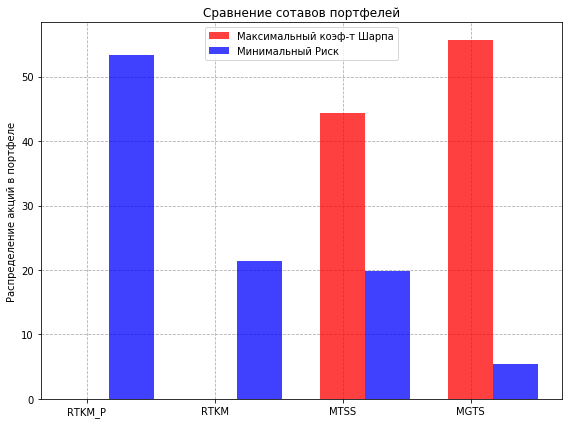

In [36]:
plt.figure(figsize=(8,6))
plt.bar(ind, max_sharpe['x'], width, color='r', alpha=0.75)
plt.bar(ind + width, min_vol['x'], width, color='b', alpha=0.75)

plt.xticks(ind, stocks)
plt.ylabel('Распределение акций в портфеле')
plt.title('Сравнение сотавов портфелей')
plt.legend(('Максимальный коэф-т Шарпа', 'Минимальный Риск'))
plt.grid(b=True, linestyle='--')

plt.tight_layout()